In [2]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
import pandas as pd
import time, warnings
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle, islice
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

In [3]:
green_data = pd.read_csv('./green.csv')
hinselmann_data = pd.read_csv('./hinselmann.csv')
schiller_data = pd.read_csv('./schiller.csv')

data = [[green_data,'green_data'], [hinselmann_data,'hinselmann_data'], [schiller_data,'schiller_data']]

In [4]:
green_data = green_data.iloc[:,green_data.columns != 'class']
hinselmann_data = hinselmann_data.iloc[:,hinselmann_data.columns != 'class']
schiller_data = schiller_data.iloc[:,schiller_data.columns != 'class']


scaler = StandardScaler()
scaler.fit(green_data)
green_scaled = scaler.transform(green_data)

In [5]:
# Set up cluster parameters
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02,right=.98,bottom=.001,top=.96,wspace=.05,hspace=.01)
plot_num = 1
1
default_base = {'quantile': .3,'eps': .3, 'damping': .9, 'preference': -200, 'n_neighbors': 10, 'n_clusters': 3}
datasets = [
(green_scaled,{'damping':.77,'preference':-240,'quantile':.2,'n_clusters':2}),
(green_scaled, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
(green_scaled, {'eps': .18, 'n_neighbors': 3}),
(green_scaled, {'eps': .15, 'n_neighbors': 2}),
(green_scaled, {}),
(green_scaled, {})]

<Figure size 1512x900 with 0 Axes>

In [6]:
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)
    X = dataset
    
    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])
    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)
    # Create cluster objects
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering( n_clusters=params['n_clusters'], linkage='ward',
    connectivity=connectivity)
    spectral = cluster.SpectralClustering( n_clusters=params['n_clusters'], eigen_solver='arpack', affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering( linkage="average", affinity="cityblock", n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture( n_components=params['n_clusters'], covariance_type='full')
    clustering_algorithms = (('MiniBatchKMeans', two_means),('AffinityPropagation', affinity_propagation),('MeanShift', ms),('SpectralClustering', spectral),('Ward', ward),('AgglomerativeClustering', average_linkage),('DBSCAN', dbscan),('Birch', birch),('GaussianMixture', gmm))

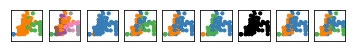

In [8]:
y_preds = {}
for name, algorithm in clustering_algorithms:
    t0 = time.time()
    # catch warnings related to kneighbors_graph
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore",message="the number of connected components of the " +"connectivity matrix is [0-9]{1,2}" +" > 1. Completing it to avoid stopping the tree early.",category=UserWarning)
        warnings.filterwarnings("ignore",message="Graph is not fully connected, spectral embedding" +" may not work as expected.",category=UserWarning)
        algorithm.fit(X)
        t1 = time.time()
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(X)
    y_preds[name] = y_pred
    plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
    if i_dataset == 0:
        plt.title(name, size=18)
    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']),int(max(y_pred) + 1))))
    # add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])
    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())
    plot_num += 1
    plt.savefig('cluster/{}.pdf'.format(name))
    